**# Data cleaning**

In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import jinja2

# 1. UNIVERSAL PATHING
# Adjust 'project_dataset' to your local folder name if different
data_folder = "project_dataset"
cash_path = os.path.join(data_folder, "extract - cash request - data analyst.csv")
fees_path = os.path.join(data_folder, "extract - fees - data analyst - .csv")

# 2. LOADING DATA
cash_request = pd.read_csv(cash_path)
fees = pd.read_csv(fees_path)

# 3. DATE CLEANING (Merged logic)
# Combining all date columns identified by the team
cash_date_cols = ["created_at", "updated_at", "moderated_at", "reimbursement_date", 
                  "cash_request_received_date", "money_back_date", "send_at", 
                  "reco_creation", "reco_last_update"]

fees_date_cols = ["created_at", "updated_at", "paid_at", "from_date", "to_date"]

# Apply conversion to cash_request
for col in cash_date_cols:
    if col in cash_request.columns:
        cash_request[col] = pd.to_datetime(cash_request[col], errors='coerce')

# Apply conversion to fees
for col in fees_date_cols:
    if col in fees.columns:
        fees[col] = pd.to_datetime(fees[col], errors='coerce')

# 4. DATA INTEGRITY FIXES
# Ensure IDs are integers for proper merging later
fees["cash_request_id"] = fees["cash_request_id"].astype("Int64")
cash_request["user_id"] = cash_request["user_id"].astype("Int64")

print("✅ System Ready: Data loaded, dates converted, and IDs formatted.")



✅ System Ready: Data loaded, dates converted, and IDs formatted.


0
0
These columns were dropped: []


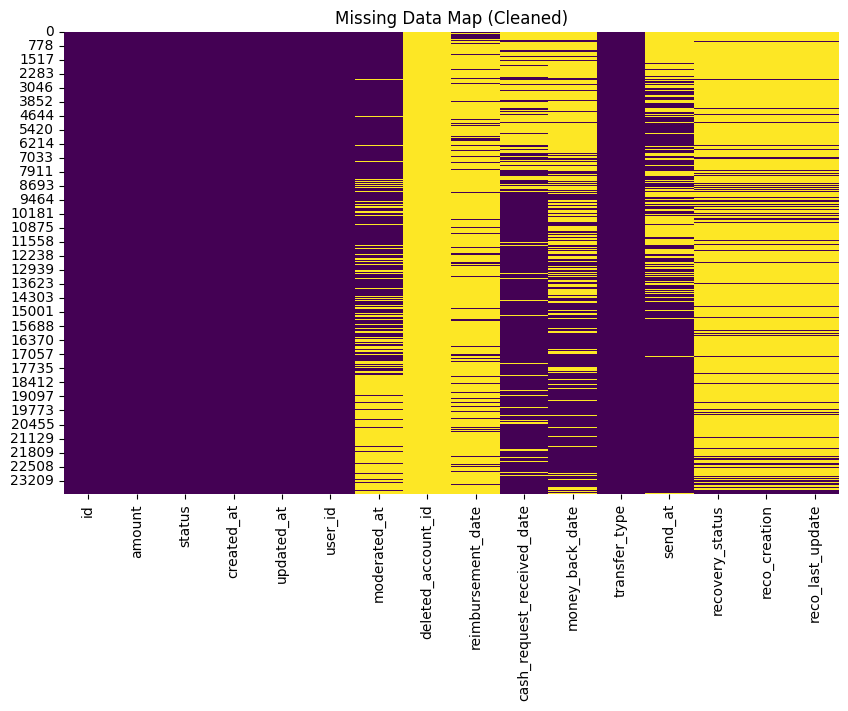

In [4]:
#Remove Duplicate
cash_request = cash_request.drop_duplicates()
fees = fees.drop_duplicates()

# Remove impossible negative amounts
fees = fees[fees["total_amount"] >= 0]

# Remove fees without a cash_request_id
fees = fees[fees["cash_request_id"].notna()]

#Identify and drop completely emppty columns
cash_request = cash_request.dropna(subset=["created_at"])
print(cash_request["created_at"].isna().sum())
cash_request = cash_request.dropna(subset=["user_id"])
print(cash_request["user_id"].isna().sum())
empty_cols = cash_request.columns[cash_request.isnull().all()]
cash_request = cash_request.drop(columns=empty_cols)

print(f"These columns were dropped: {list(empty_cols)}")

#Take a look at the remaining missing data 
plt.figure(figsize=(10, 6))
sns.heatmap(cash_request.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Map (Cleaned)')
plt.show()



In [5]:
#Cohort Creation

#First Cash request per User
cash_request["cohort_month"] = (cash_request.groupby("user_id")["created_at"].transform(min).dt.to_period("M"))

#Activity month(month of each request)
cash_request["request_month"] = cash_request["created_at"].dt.to_period("M")

cash_request.head()


C:\Users\PC GAMING\AppData\Local\Temp\ipykernel_28788\1189478578.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request["cohort_month"] = (cash_request.groupby("user_id")["created_at"].transform(min).dt.to_period("M"))
C:\Users\PC GAMING\AppData\Local\Temp\ipykernel_28788\1189478578.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_request["request_month"] = cash_request["created_at"].dt.to_period("M")


,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,cohort_month,request_month
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00:00,2019-12-11 16:47:42.407830+00:00,804,2019-12-11 16:47:42.405646+00:00,NaN,2020-01-09 19:05:21.596363+00:00,NaT,NaT,regular,NaT,NaN,NaT,NaT,2019-12,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780+00:00,2019-12-11 14:24:22.900054+00:00,231,2019-12-11 14:24:22.897988+00:00,NaN,2020-01-09 19:50:12.347780+00:00,NaT,NaT,regular,NaT,NaN,NaT,NaT,2019-12,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460+00:00,2019-12-11 09:46:59.779773+00:00,191,2019-12-11 09:46:59.777728+00:00,NaN,2020-01-09 19:13:35.825041+00:00,NaT,NaT,regular,NaT,NaN,NaT,NaT,2019-12,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00:00,2019-12-18 14:26:18.136163+00:00,761,2019-12-18 14:26:18.128407+00:00,NaN,2020-01-09 19:16:10.879606+00:00,NaT,NaT,regular,NaT,NaN,NaT,NaT,2019-12,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00:00,2020-05-07 09:21:55.340080+00:00,7686,2020-05-07 09:21:55.320193+00:00,NaN,NaT,NaT,NaT,regular,NaT,NaN,NaT,NaT,2020-05,2020-05


In [6]:
#Frequency of service usage
frequency_usage = (
    cash_request.groupby(["cohort_month", "request_month"])
      .agg(request_count=("id", "count"))
      .reset_index()
)


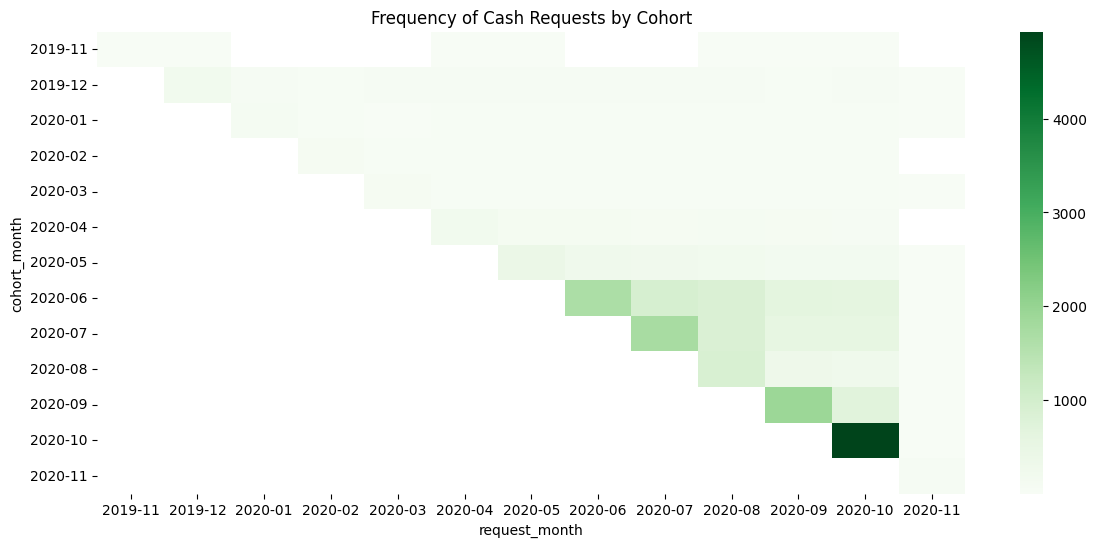

In [7]:
#Rows = Cohort months:Each row is a group of users who made their first cash request in that month
#Columns = Request months:These are the calendar months when users made cash requests.
#Cells = Number of cash requests (request_count)
#Color bar on the right Shows the scale of request_count (from 0 up to ~4000).


freq_pivot = frequency_usage.pivot(index="cohort_month", columns="request_month", values="request_count")
plt.figure(figsize=(14,6))
sns.heatmap(freq_pivot, cmap="Greens", annot=False)
plt.title("Frequency of Cash Requests by Cohort")
plt.show()


In [8]:
#Incident Rate
#Filter incident fees
incident_fees = fees[fees["type"] == "incident"]
incident_fees["fee_month"] = incident_fees["created_at"].dt.to_period("M")

C:\Users\PC GAMING\AppData\Local\Temp\ipykernel_28788\1159155404.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  incident_fees["fee_month"] = incident_fees["created_at"].dt.to_period("M")


In [9]:
#Join with Cash request to get cohort
incident = incident_fees.merge(
    cash_request[["id", "user_id", "cohort_month"]],
    left_on="cash_request_id",
    right_on="id",
    how="left"
)


In [10]:
#Compute incident count
incident_rate = (
    incident.groupby(["cohort_month", "fee_month"])
            .agg(incident_count=("id_x", "count"))
            .reset_index()
)


In [11]:
#Merge with request frequency_usage
incident_rate = incident_rate.merge(
    frequency_usage,
    left_on=["cohort_month", "fee_month"],
    right_on=["cohort_month", "request_month"],
    how="left"
)

incident_rate["incident_rate"] = incident_rate["incident_count"] / incident_rate["request_count"]
incident_rate

,cohort_month,fee_month,incident_count,request_month,request_count,incident_rate
0,2019-12,2020-07,16,2020-07,63,0.253968
1,2019-12,2020-08,6,2020-08,76,0.078947
2,2019-12,2020-09,11,2020-09,50,0.220000
3,2019-12,2020-10,9,2020-10,71,0.126761
4,2020-01,2020-06,1,2020-06,25,0.040000
5,2020-01,2020-07,2,2020-07,28,0.071429
6,2020-01,2020-08,6,2020-08,22,0.272727
7,2020-01,2020-09,6,2020-09,22,0.272727
8,2020-01,2020-10,6,2020-10,24,0.250000
9,2020-02,2020-07,3,2020-07,37,0.081081


In [12]:
# First cash request date per user
user_first = (
    cash_request.groupby("user_id", as_index=False)["created_at"]
    .min()
    .rename(columns={"created_at": "first_cash_request_at"})
)
# Cohort = month of first request
user_first["cohort"] = user_first["first_cash_request_at"].dt.to_period("M")
user_first.head()

C:\Users\PC GAMING\AppData\Local\Temp\ipykernel_28788\3611460919.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  user_first["cohort"] = user_first["first_cash_request_at"].dt.to_period("M")


,user_id,first_cash_request_at,cohort
0,34,2020-04-20 15:50:21.187257+00:00,2020-04
1,35,2019-12-13 20:27:38.106778+00:00,2019-12
2,47,2019-11-19 13:57:53.511561+00:00,2019-11
3,52,2019-12-17 09:01:12.584634+00:00,2019-12
4,53,2019-12-21 11:39:03.844436+00:00,2019-12


In [13]:
fees_paid = fees[fees["paid_at"].notna()].copy()
# If total_amount is text, ensure numeric
fees_paid["total_amount"] = pd.to_numeric(fees_paid["total_amount"], errors="coerce").fillna(0)
fees_paid.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150+00:00,2020-10-13 14:25:09.396112+00:00,2020-12-17 14:50:07.470110+00:00,NaT,NaT,after
1,6961,11714,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00:00,2020-10-13 14:25:15.537063+00:00,2020-12-08 17:13:10.459080+00:00,NaT,NaT,after
2,16296,23371,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00:00,2020-10-23 10:10:58.352994+00:00,2020-11-04 19:34:37.432910+00:00,NaT,NaT,after
3,20775,26772,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00:00,2020-10-31 15:46:53.643982+00:00,2020-11-19 05:09:22.500223+00:00,NaT,NaT,after
4,11242,19350,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00:00,2020-10-13 14:25:03.267983+00:00,2020-11-02 14:45:20.355598+00:00,NaT,NaT,after


In [14]:
df = fees_paid.merge(
    cash_request[["id", "user_id", "created_at"]],
    left_on="cash_request_id",
    right_on="id",
    how="left",
    suffixes=("_fee", "_cash")
)
# Add cohort info
df = df.merge(
    user_first[["user_id", "cohort"]],
    on="user_id",
    how="left"
)
df.head()

,id_fee,cash_request_id,type,status,category,total_amount,reason,created_at_fee,updated_at,paid_at,from_date,to_date,charge_moment,id_cash,user_id,created_at_cash,cohort
0,6537,14941,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150+00:00,2020-10-13 14:25:09.396112+00:00,2020-12-17 14:50:07.470110+00:00,NaT,NaT,after,14941.0,35661,2020-09-07 10:46:57.780263+00:00,2020-09
1,6961,11714,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00:00,2020-10-13 14:25:15.537063+00:00,2020-12-08 17:13:10.459080+00:00,NaT,NaT,after,11714.0,16158,2020-08-10 13:15:54.291488+00:00,2020-06
2,16296,23371,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00:00,2020-10-23 10:10:58.352994+00:00,2020-11-04 19:34:37.432910+00:00,NaT,NaT,after,23371.0,81575,2020-10-23 10:10:43.278601+00:00,2020-10
3,20775,26772,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00:00,2020-10-31 15:46:53.643982+00:00,2020-11-19 05:09:22.500223+00:00,NaT,NaT,after,26772.0,94393,2020-10-31 15:46:14.156730+00:00,2020-10
4,11242,19350,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00:00,2020-10-13 14:25:03.267983+00:00,2020-11-02 14:45:20.355598+00:00,NaT,NaT,after,NaN,<NA>,NaT,NaT


In [15]:
df = df.dropna(subset=["paid_at", "cohort"])
# Ensure correct types
df["cohort"] = df["cohort"].astype("period[M]")
df["revenue_month"] = df["paid_at"].dt.to_period("M")
# Calculate months since cohort safely
df["cohort_month"] = (df["revenue_month"] - df["cohort"]).apply(lambda x: x.n)
# Keep valid timeline only
df = df[df["cohort_month"] >= 0]

C:\Users\PC GAMING\AppData\Local\Temp\ipykernel_28788\1802913357.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["revenue_month"] = df["paid_at"].dt.to_period("M")


In [16]:
df[["user_id", "cohort", "paid_at", "revenue_month", "cohort_month", "total_amount"]].head()

,user_id,cohort,paid_at,revenue_month,cohort_month,total_amount
0,35661,2020-09,2020-12-17 14:50:07.470110+00:00,2020-12,3,5.0
1,16158,2020-06,2020-12-08 17:13:10.459080+00:00,2020-12,6,5.0
2,81575,2020-10,2020-11-04 19:34:37.432910+00:00,2020-11,1,5.0
3,94393,2020-10,2020-11-19 05:09:22.500223+00:00,2020-11,1,5.0
5,90386,2020-10,2020-11-09 19:10:14.474070+00:00,2020-11,1,5.0


In [17]:
cohort_revenue = (
    df.groupby(["cohort", "cohort_month"], as_index=False)["total_amount"]
    .sum()
    .rename(columns={"total_amount": "revenue"})
)
cohort_revenue.head()

,cohort,cohort_month,revenue
0,2019-11,8,5.0
1,2019-11,10,5.0
2,2019-11,11,10.0
3,2019-11,12,5.0
4,2019-12,6,10.0


In [18]:
cohort_matrix = cohort_revenue.pivot_table(
    index="cohort",
    columns="cohort_month",
    values="revenue",
    aggfunc="sum",
    fill_value=0
).sort_index()
cohort_matrix

cohort_month,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2019-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,10.0,5.0
2019-12,0.0,0.0,0.0,0.0,0.0,0.0,10.0,55.0,130.0,210.0,295.0,245.0,55.0
2020-01,0.0,0.0,0.0,0.0,0.0,10.0,55.0,45.0,90.0,145.0,70.0,40.0,35.0
2020-02,0.0,0.0,0.0,0.0,20.0,30.0,45.0,125.0,210.0,170.0,10.0,0.0,5.0
2020-03,0.0,0.0,0.0,20.0,55.0,40.0,105.0,175.0,140.0,20.0,5.0,5.0,0.0
2020-04,0.0,0.0,45.0,125.0,115.0,310.0,470.0,260.0,225.0,20.0,0.0,0.0,0.0
2020-05,0.0,95.0,360.0,340.0,655.0,1005.0,600.0,255.0,75.0,20.0,0.0,0.0,0.0
2020-06,430.0,1265.0,1070.0,2700.0,3930.0,2600.0,1080.0,285.0,110.0,0.0,0.0,0.0,0.0
2020-07,695.0,1080.0,2370.0,3545.0,2330.0,855.0,215.0,140.0,0.0,0.0,0.0,0.0,0.0


In [19]:
cohort_matrix.style.format("{:,.2f}")

cohort_month,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2019-11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,5.00,10.00,5.00
2019-12,0.00,0.00,0.00,0.00,0.00,0.00,10.00,55.00,130.00,210.00,295.00,245.00,55.00
2020-01,0.00,0.00,0.00,0.00,0.00,10.00,55.00,45.00,90.00,145.00,70.00,40.00,35.00
2020-02,0.00,0.00,0.00,0.00,20.00,30.00,45.00,125.00,210.00,170.00,10.00,0.00,5.00
2020-03,0.00,0.00,0.00,20.00,55.00,40.00,105.00,175.00,140.00,20.00,5.00,5.00,0.00
2020-04,0.00,0.00,45.00,125.00,115.00,310.00,470.00,260.00,225.00,20.00,0.00,0.00,0.00
2020-05,0.00,95.00,360.00,340.00,655.00,"1,005.00",600.00,255.00,75.00,20.00,0.00,0.00,0.00
2020-06,430.00,"1,265.00","1,070.00","2,700.00","3,930.00","2,600.00","1,080.00",285.00,110.00,0.00,0.00,0.00,0.00
2020-07,695.00,"1,080.00","2,370.00","3,545.00","2,330.00",855.00,215.00,140.00,0.00,0.00,0.00,0.00,0.00


## Average days to recovery metric

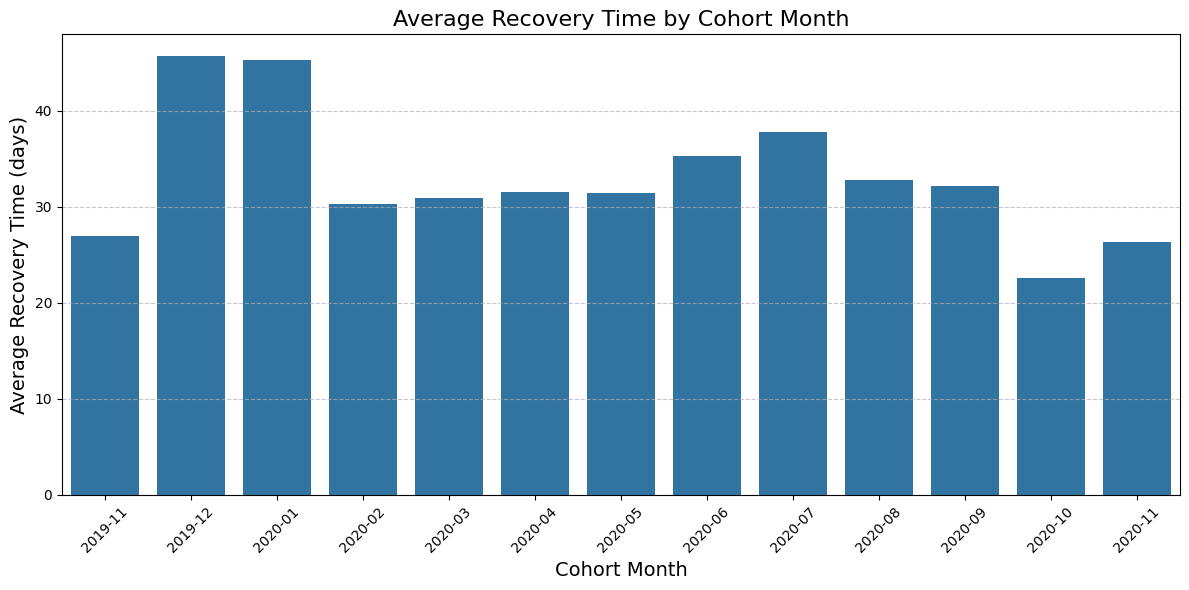

In [22]:
# fix timezone
cash_request['cash_request_received_date'] =pd.to_datetime(cash_request['cash_request_received_date']).dt.tz_localize(None)
cash_request['money_back_date'] =pd.to_datetime(cash_request['money_back_date']).dt.tz_localize(None)

# calcululate the revovery time in days
cash_request['days_to_recovery'] = (cash_request['money_back_date'] - cash_request['cash_request_received_date']).dt.days

# ensure the days_to_recovery is not negative
recovery_df = cash_request[cash_request['days_to_recovery'] >= 0]

avg_recovery = recovery_df.groupby('cohort_month')['days_to_recovery'].mean().reset_index()

avg_recovery['cohort_month'] = avg_recovery['cohort_month'].astype(str)

# plot the average recovery time
avg_recovery_plot = avg_recovery.copy()
avg_recovery_plot['cohort_month_str'] = avg_recovery_plot['cohort_month'].astype(str)

plt.figure(figsize=(12,6))
sns.barplot(data=avg_recovery_plot, x='cohort_month_str', y='days_to_recovery')

plt.title('Average Recovery Time by Cohort Month', fontsize=16)
plt.xlabel('Cohort Month', fontsize=14)
plt.ylabel('Average Recovery Time (days)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



In [ ]:
# 1. Identify incidents from fees
# Get unique IDs as a set (array) 
incident_ids = fees[fees['type'] == 'incident']['cash_request_id'].unique()
# 2. Map valid incidents to cash_request using isin()
cash_request['is_incident_fee'] = cash_request['id'].isin(incident_ids).astype(int)
# 3. Calculate Incident Rate per Cohort
# Group by cohort_month to get the mean rate
incident_rate_analysis = cash_request.groupby('cohort_month')['is_incident_fee'].mean().reset_index()
incident_rate_analysis.rename(columns={'is_incident_fee': 'Incident Rate', 'cohort_month': 'Cohort'}, inplace=True)e
# Ensure both keys are strings so they match reliably
avg_recovery['cohort_month'] = avg_recovery['cohort_month'].astype(str)
incident_rate_analysis['Cohort'] = incident_rate_analysis['Cohort'].astype(str)
# 5. Create Risk Summary
# Merge avg_recovery with our new analysis
risk_summary = pd.merge(
    avg_recovery, 
    incident_rate_analysis, 
    left_on='cohort_month', 
    right_on='Cohort'
).drop('Cohort', axis=1)
# 6. Format Metrics
risk_summary['Incident Rate_%'] = (risk_summary['Incident Rate'] * 100).round(2)
print("Dataframe 'risk_summary' ready for plotting.")
print(risk_summary.head())

Dataframe 'risk_summary' ready for plotting.
  cohort_month  days_to_recovery cohort_month_str  Incident Rate  \
0      2019-11         27.000000          2019-11       0.000000   
1      2019-12         45.664820          2019-12       0.033595   
2      2020-01         45.225352          2020-01       0.034268   
3      2020-02         30.253968          2020-02       0.035461   
4      2020-03         30.943820          2020-03       0.058824   

   Incident Rate_%  
0             0.00  
1             3.36  
2             3.43  
3             3.55  
4             5.88  


In [ ]:
# Get unique IDs as a set (array)
incident_ids = fees[fees['type'] == 'incident']['cash_request_id'].unique()
# 2. Map valid incidents to cash_request using isin()
cash_request['is_incident_fee'] = cash_request['id'].isin(incident_ids).astype(int)
# 3. Calculate Incident Rate per Cohort
# Group by cohort_month to get the mean rate
incident_rate_analysis = cash_request.groupby('cohort_month')['is_incident_fee'].mean().reset_index()
incident_rate_analysis.rename(columns={'is_incident_fee': 'Incident Rate', 'cohort_month': 'Cohort'}, inplace=True)

# Ensure both keys are strings so they match reliably
avg_recovery['cohort_month'] = avg_recovery['cohort_month'].astype(str)
incident_rate_analysis['Cohort'] = incident_rate_analysis['Cohort'].astype(str)
# Merge avg_recovery with our new analysis
risk_summary = pd.merge(
    avg_recovery, 
    incident_rate_analysis, 
    left_on='cohort_month', 
    right_on='Cohort'
).drop('Cohort', axis=1)
# 6. Format Metrics
risk_summary['Incident Rate_%'] = (risk_summary['Incident Rate'] * 100).round(2)
print("Risk Dashboard")
print(risk_summary.head())

Risk Dashboard
  cohort_month  days_to_recovery cohort_month_str  Incident Rate  \
0      2019-11         27.000000          2019-11       0.000000   
1      2019-12         45.664820          2019-12       0.033595   
2      2020-01         45.225352          2020-01       0.034268   
3      2020-02         30.253968          2020-02       0.035461   
4      2020-03         30.943820          2020-03       0.058824   

   Incident Rate_%  
0             0.00  
1             3.36  
2             3.43  
3             3.55  
4             5.88  


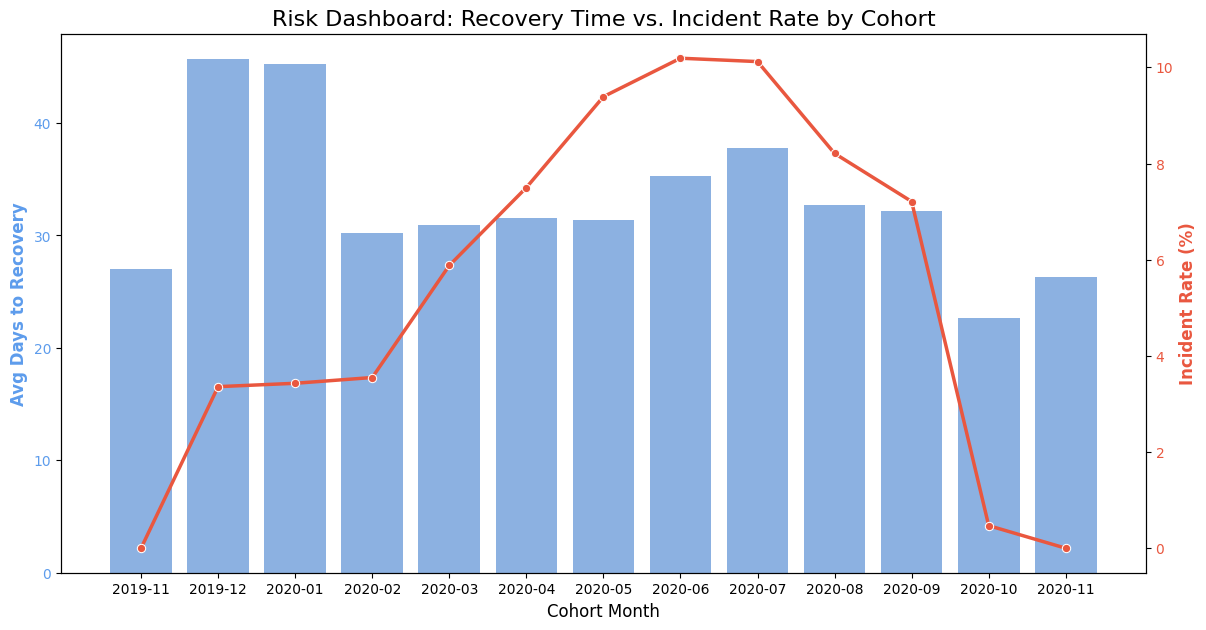

In [ ]:

# Create figure with secondary y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))
# Plot Recovery Time (Bars)
sns.barplot(
    data=risk_summary, 
    x='cohort_month', 
    y='days_to_recovery', 
    ax=ax1, 
    color='#5D9CEC',  
    alpha=0.8
)
ax1.set_ylabel('Avg Days to Recovery', color='#5D9CEC', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#5D9CEC')
ax1.set_xlabel('Cohort Month', fontsize=12)
# Create a twin axis for Incident Rate
ax2 = ax1.twinx()
# Plot Incident Rate (Line)
sns.lineplot(
    data=risk_summary, 
    x='cohort_month', 
    y='Incident Rate_%', 
    ax=ax2, 
    color='#E9573F',
    marker='o', 
    linewidth=2.5
)
ax2.set_ylabel('Incident Rate (%)', color='#E9573F', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#E9573F')

plt.title('Risk Dashboard: Recovery Time vs. Incident Rate by Cohort', fontsize=16)
plt.grid(False) 
plt.show()